In [1]:
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd

import warnings

import h5py

import os

# for kmeans
from sklearn.cluster import KMeans


# for moG
from sklearn import mixture

In [2]:
import sklearn

In [3]:
sklearn.__version__

'0.23.1'

In [5]:
"""
define normalizing function
"""
def normalize(data, mode=None):
    """
    normalizes data with respect to mode
    :data: shape: (n,tpts)
    :param mode: in ['z_score', 'std_norm', 'max_division']
    
    """
    assert mode in ['z_score', 'std_norm', 'max_division']
    if mode=='z_score':
        return (data - data.mean(axis=1)[:, None])/(data.std(axis=1)[:,None])
    elif mode=='std_norm':
        return data /(data.std(axis=1)[:,None])
    elif mode=='max_division':
        return data /(np.abs(data).max(axis=1)[:,None])

## Load tuning curves 

In [6]:
"""
read in the tuning curve data
(excel file)
"""
filepath = '../data/HC_voltage_recordings/'
filename = 'Responses_all_v2.xlsx'
df_tuning_curves = pd.read_excel (filepath+filename, header =1 )[::-1].T
# make wavelengths to header
df_tuning_curves.columns = df_tuning_curves.iloc[0]
df_tuning_curves = df_tuning_curves.drop(df_tuning_curves.index[0])

wavelengths = df_tuning_curves.columns.values

"""
initialize raw and normalized data
"""
tuning_raw = df_tuning_curves.to_numpy()
tuning_norm = normalize(tuning_raw, mode='max_division')



#### check loaded data

In [7]:
df_tuning_curves

Wavelength,355.0,402.0,420.0,456.0,491.0,513.0,542.0,611.0
HC1,0.228779,0.437928,0.866657,0.894033,0.314220,0.722772,0.354406,0.426076
HC2,0.926392,0.753396,0.704743,0.999242,0.637182,0.060913,0.049760,0.132069
HC3,1.053282,1.149698,0.647530,-0.068778,-0.281926,-0.491326,-0.227964,0.267404
HC4,0.985538,0.405315,1.039922,0.042519,0.070940,-0.333571,-0.068744,0.221999
HC5,2.402303,1.918531,1.759847,0.941754,-0.725536,-0.427837,0.839617,1.565798
...,...,...,...,...,...,...,...,...
HC82,0.834269,0.863258,0.961381,1.162095,0.869433,1.119428,0.884080,0.676092
HC83,1.179572,1.557391,1.487780,1.817669,1.785849,2.128555,1.799031,1.205026
HC84,0.987525,0.601516,0.988916,1.231806,1.179957,1.604861,1.307633,1.089958
HC85,0.978224,1.099223,1.209901,1.129070,1.051094,1.156382,1.231834,1.069757


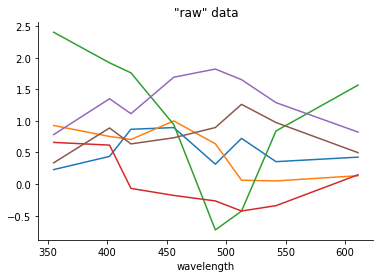

In [8]:
plt.title('"raw" data')
for i in  [0,1,4,9,34,69]:
    plt.plot(df_tuning_curves.iloc[i])
plt.xlabel('wavelength')
sns.despine()

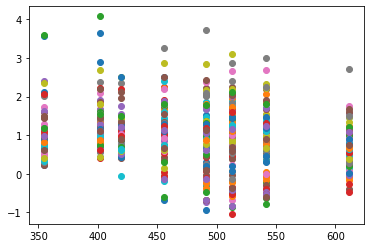

In [5]:
plt.plot(df_tuning_curves.T, 'o')
plt.show()

### Load voltage recordings

In [28]:
filepath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/data/HC_voltage_recordings/'


In [29]:
# This data needs to be downloaded from dryad  

"""
read in the voltage traces
"""
filepath = None # path to the downloaded data
filename = 'Traces_2secblank.txt'
traces_raw = np.loadtxt(filepath+filename,skiprows=1).T

# normalize
traces_norm = normalize(traces_raw, mode='max_division')

# and the corresponding stimulus
#Value 1 means there is flash. The colour of the flash starts from long-wavelength to short-wavelength. 
#The wavelength is the same as in the tuning curve axis.

# in Traces_2secblank.txt 2 sec. of no stim is added before starting
dt = 0.001956

filename='stims.xlsx'
df_stim = pd.read_excel (filepath+filename).T
stim = df_stim.to_numpy()[0]

# add 2 sec
stim = np.hstack([np.zeros(int(np.round(2/dt))), stim])

# cut to same length
stim = stim[:24005]



## MoG clustering on tuning curves

In [9]:
### choose data
data = tuning_norm

random_state = 1


n_clusters=3
# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=n_clusters, 
                              covariance_type='diag',
                             random_state=random_state) # full
clf.fit(data)

y_pred = clf.predict(data)



# get partition

partition_moG = [[] for _ in range(n_clusters)]
for i in range(n_clusters):
    partition_moG[i] = np.arange(len(y_pred))[y_pred==i]

    
number_cluster_elements = [partition_moG[0].shape[0] , 
                           partition_moG[1].shape[0], 
                           partition_moG[2].shape[0]]

print(number_cluster_elements)

[15, 58, 13]


number of cluster elements [15, 58, 13]


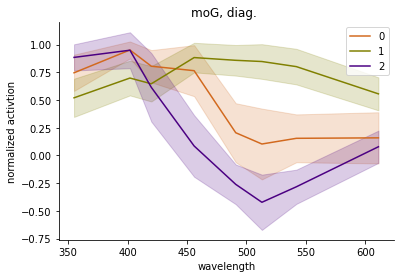

In [10]:
colors = ['chocolate', 'olive', 'indigo', 'blue', 'green' ]

plt.title('moG, diag. ')

for i in range(3):
    mean = clf.means_[i]
    #std =     np.sqrt(clf.covariances_)[i]
    #mean_data = data[partition_moG[i]].mean(axis=0)
    std =  data[partition_moG[i]].std(axis=0)
    
    plt.plot(wavelengths,mean, color=colors[i],
             label=i)
    #plt.plot(wavelengths,mean_data, 
    #         color=colors[i],
     #        label=i,
     #        ls='--')

    plt.fill_between(wavelengths,
                mean-std, 
                 mean+std,
                alpha=0.2,
                color=colors[i])
plt.legend()

sns.despine()
plt.legend()
plt.ylabel('normalized activtion')
plt.xlabel('wavelength')


print('number of cluster elements',number_cluster_elements)



#### Check out the number of clusters (compare via BIC)

In [11]:
"""
one run
"""

random_state = 1
data = tuning_norm

lowest_bic = np.infty
bic = []
aic = []

n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,
                                     random_state=random_state)
        gmm.fit(data)
        bic.append(gmm.bic(data))
        aic.append(gmm.aic(data))

        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
aic = np.array(aic)


clf = best_gmm
bars = []

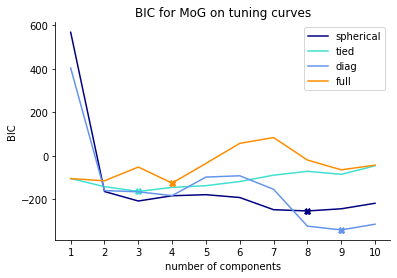

In [13]:

colors = ['navy', 'turquoise', 'cornflowerblue',
                              'darkorange']

bic_split = bic.reshape(4,-1)
x = np.arange(1,n_components_range[-1]+1)

plt.title('BIC for MoG on tuning curves')
for i in range(4):
    plt.plot(x, bic_split[i], label=cv_types[i], 
            color=colors[i])
    plt.plot(x[np.argmin(bic_split[i])], 
               np.min(bic_split[i]),
             'X',
            color=colors[i])

plt.xticks(np.arange(1,n_components_range[-1]+1))
plt.legend()
plt.xlabel('number of components')
plt.ylabel('BIC')
sns.despine()

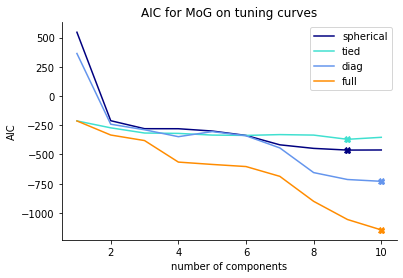

In [14]:

colors = ['navy', 'turquoise', 'cornflowerblue',
                              'darkorange']

aic_split = aic.reshape(4,-1)
x = np.arange(1,n_components_range[-1]+1)

plt.title('AIC for MoG on tuning curves')

for i in range(4):
    plt.plot(x, aic_split[i], label=cv_types[i], 
            color=colors[i])
    plt.plot(x[np.argmin(aic_split[i])], 
               np.min(aic_split[i]),
             'X',
            color=colors[i])
    
plt.legend()
plt.xlabel('number of components')
plt.ylabel('AIC')
sns.despine()

### Run for 3 clusters

In [17]:
"""
run multiple times and compare BIC (fur 3 clusters)
"""


data = tuning_norm
#data = np.hstack([tuning_norm, tuning_norm_diff])

n_clusters = 3

verbose=False

bic = []
aic = []
y_pred_all = []
gmm_all = []

random_states = np.arange(1000)

cv_types = ['diag'] #['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for random_state in random_states:

        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_clusters,
                                      covariance_type=cv_type,
                                     random_state=random_state)
        gmm.fit(data)
        bic.append(gmm.bic(data))
        aic.append(gmm.aic(data))
        
        y_pred = gmm.predict(data)
        y_pred_all.append(y_pred)
        
        gmm_all.append(gmm)


        
        
        if verbose:
            print('finished random_state', random_state)

bic = np.array(bic)
aic = np.array(aic)
y_pred_all = np.array(y_pred_all)

# get partition

partition_moG_all = [[[] for _ in range(n_clusters)] for i in range(len(random_states))]
for r in range(len(random_states)):
    for i in range(n_clusters):
        partition_moG_all[r][i] = np.arange(len(y_pred_all[0]))[y_pred_all[r]==i]

        
        
"""
compare clusters with same BIC 
"""

min_bic = np.min(bic)

best_indeces = random_states[np.isclose(bic, min_bic)]

n_best = len(best_indeces)

# get partition best

partition_moG_best = [[[] for _ in range(n_clusters)] for i in range(len(best_indeces))]
for r in range(len(best_indeces)):
    for i in range(n_clusters):
        partition_moG_best[r][i] = np.arange(len(y_pred_all[0]))[y_pred_all[r]==i]

# get number of cluster elements
n_cluster_elements = []
for i in range(0, len(best_indeces)):
    n_cluster_elements.append([ partition_moG_best[i][0].shape[0] , 
                               partition_moG_best[i][1].shape[0], 
                               partition_moG_best[i][2].shape[0]])

 
    
# sorting in ascending number of elements order
partition_sorted = []
for  i in range(len(best_indeces)):    
    order = np.argsort(n_cluster_elements[i])
    partition_sorted.append([partition_moG_best[i][item] for item in  order])
    n_cluster_elements[i].sort()


In [18]:
best_indeces

array([ 20,  23,  66,  78,  97, 210, 224, 282, 313, 507, 655, 656, 662])

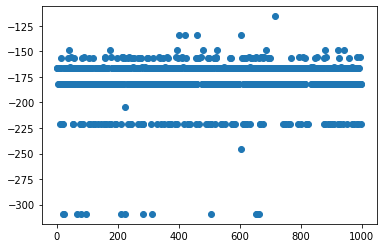

In [19]:
plt.plot(bic, 'o')


In [20]:
# check here for reference partition
for i in range(n_best):
    print(partition_sorted[i][0])

[ 2  3  6  8  9 10 11 12 16 44 52 53 54]
[ 2  3  6  8  9 10 11 12 16 44 52 53 54]
[ 1 13 19 35 40 41 42 43 46 47 50 60]
[ 0  1 13 19 40 42 45 46 47 50 58 60]
[ 1 13 19 35 40 41 42 43 46 47 50 60]
[ 1 13 19 35 40 41 42 43 46 47 50 60]
[ 2  3  6  8  9 10 11 12 16 44 52 53 54]
[ 0  1 13 19 40 42 45 46 47 50 58 60]
[ 1 13 19 35 40 41 42 43 46 47 50 60]
[ 0  1 13 19 40 42 45 46 47 50 58 60]
[ 0  1  3  4  5 13 19 40 42 45 46 47 50 58 60]
[ 2  3  6  8  9 10 11 12 16 44 52 53 54]
[ 2  3  6  8  9 10 11 12 16 44 52 53 54]


In [22]:
"""
get coherent clusterings
"""
    
#  get coherent partitions
reference_number=3 # refering to index in partition_sorted (already filtered for best)
reference_partition = np.copy(partition_sorted[reference_number][0])
coherent_indeces = []

for i in range(n_best):
    if np.all(partition_sorted[i][0] == reference_partition):
        coherent_indeces.append(i)
        
print('Clusterings with same (best) BIC: ', n_best)
print('within these with same partition: ',len(coherent_indeces))

Clusterings with same (best) BIC:  13
within these with same partition:  3


<ipython-input-22-72556c3b6679>:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(partition_sorted[i][0] == reference_partition):


In [23]:
"""
final partition used:
"""
partition_final = [np.array([ 0,  1, 13, 19, 40, 42, 45, 46, 47, 50, 58, 60]),
 np.array([ 2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 16, 35, 41, 43, 44, 52, 53,
        54, 55]),
 np.array([ 7, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 36, 37, 38, 39, 48, 49, 51, 56, 57, 59, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85])]

In [24]:

for i in coherent_indeces:
    print(partition_sorted[i][0])

[ 0  1 13 19 40 42 45 46 47 50 58 60]
[ 0  1 13 19 40 42 45 46 47 50 58 60]
[ 0  1 13 19 40 42 45 46 47 50 58 60]


number of cluster elements [12, 19, 55]


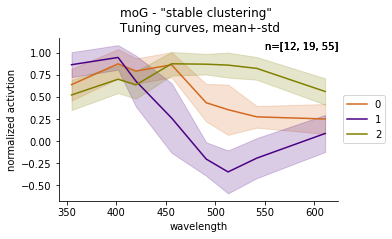

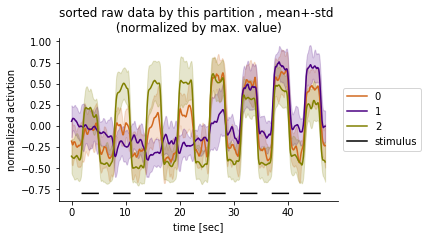

In [30]:
"""
final plot with shaded stds 
"""

save = False
colors = ['chocolate','indigo',  'olive',  ]

#partition_to_use = partition_final

# which of the coherent clusterings to choose
nc = coherent_indeces[0]


data = tuning_norm


plt.figure(1,figsize=(5,3))
plt.title('moG - "stable clustering" \n Tuning curves, mean+-std')

for i in range(3):
    mean = data[partition_sorted[nc][i]].mean(axis=0)
    #std =     np.sqrt(clf.covariances_)[i]
    #mean_data = data[partition_moG[i]].mean(axis=0)
    std =  data[partition_sorted[nc][i]].std(axis=0)
    
    plt.plot(wavelengths,mean, color=colors[i],
             label=i)
    #plt.plot(wavelengths,mean_data, 
    #         color=colors[i],
     #        label=i,
     #        ls='--')

    plt.fill_between(wavelengths,
                mean-std, 
                 mean+std,
                alpha=0.2,
                color=colors[i])
    
    plt.text(550,1.05,'n='+str(n_cluster_elements[nc]))

plt.legend()

sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.ylabel('normalized activtion')
plt.xlabel('wavelength')

print('number of cluster elements',n_cluster_elements[nc])

if save:
    filename = 'tuning_curves_clustered'
    plt.savefig(filename+'.png', dpi=200, format='png',  bbox_inches='tight')




plt.show()



"""
plot raw traces of this clustering
"""

# create nan_stimulus
stim_nan = np.array(np.copy(stim),dtype=float)
stim_nan[stim_nan==0] = np.nan


data = traces_norm
partition = partition_sorted[nc]

time = np.arange(len(stim))*dt

plt.figure(2,figsize=(5,3))

plt.title('sorted raw data by this partition , mean+-std \n (normalized by max. value) ')
for i in range(3):
    mean = data[partition[i]].mean(axis=0)
    std =  data[partition[i]].std(axis=0)
    plt.plot(time,mean, color=colors[i],
             label=i)

    plt.fill_between(time,
                mean-std, 
                 mean+std,
                alpha=0.2,
                color=colors[i])
 
# plot stim 
plt.plot(time, 
         -stim_nan*0.8,
        label='stimulus',
        color='black')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    

sns.despine()
plt.ylabel('normalized activtion')
plt.xlabel('time [sec]')

if save:
    filename = 'raw_traces_clustered_1'
    plt.savefig(filename+'.png', dpi=200, format='png',  bbox_inches='tight')



plt.show()


number of cluster elements [12, 19, 55]


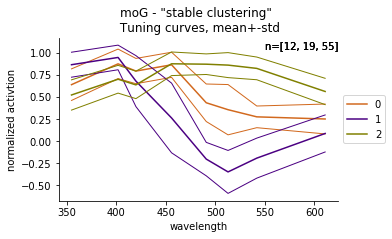

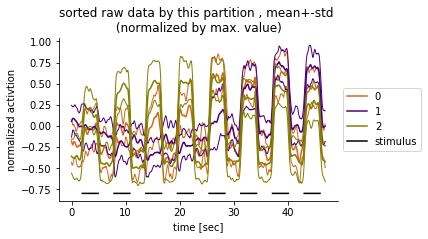

In [31]:
"""
final plot with line stds
"""

save = False
colors = ['chocolate','indigo',  'olive',  ]


# which of the coherent clusterings to choose
nc = coherent_indeces[0]


data = tuning_norm


plt.figure(1,figsize=(5,3))
plt.title('moG - "stable clustering" \n Tuning curves, mean+-std')

for i in range(3):
    mean = data[partition_sorted[nc][i]].mean(axis=0)
    #std =     np.sqrt(clf.covariances_)[i]
    #mean_data = data[partition_moG[i]].mean(axis=0)
    std =  data[partition_sorted[nc][i]].std(axis=0)
    
    plt.plot(wavelengths,mean, color=colors[i],
             label=i)


    
    plt.plot(wavelengths,
                mean-std, 
                color=colors[i],
            lw=1)
    plt.plot(wavelengths,
                mean+std, 
                color=colors[i],
            lw=1)
    
    plt.text(550,1.05,'n='+str(n_cluster_elements[nc]))

plt.legend()

sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.ylabel('normalized activtion')
plt.xlabel('wavelength')

print('number of cluster elements',n_cluster_elements[nc])

if save:
    filename = 'tuning_curves_clustered_noalpha'
    plt.savefig(filename+'.png', dpi=200, format='png',  bbox_inches='tight')




plt.show()



"""
plot raw traces of this clustering
"""

# create nan_stimulus
stim_nan = np.array(np.copy(stim),dtype=float)
stim_nan[stim_nan==0] = np.nan


data = traces_norm
partition = partition_sorted[nc]

time = np.arange(len(stim))*dt

plt.figure(2,figsize=(5,3))

plt.title('sorted raw data by this partition , mean+-std \n (normalized by max. value) ')
for i in range(3):
    mean = data[partition[i]].mean(axis=0)
    std =  data[partition[i]].std(axis=0)
    plt.plot(time,mean, color=colors[i],
             label=i)

    plt.plot(time,
                mean-std, 
                color=colors[i],
            lw=1)
    plt.plot(time,
                mean+std, 
                color=colors[i],
            lw=1)
    
 
# plot stim 
plt.plot(time, 
         -stim_nan*0.8,
        label='stimulus',
        color='black')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    

sns.despine()
plt.ylabel('normalized activtion')
plt.xlabel('time [sec]')

if save:
    filename = 'raw_traces_clustered_noalpha'
    plt.savefig(filename+'.png', dpi=200, format='png',  bbox_inches='tight')



plt.show()


In [41]:
"""
extract data
"""


partition = partition_sorted[nc]

# for tuning curves
data = tuning_norm
tuning_cluster_percentiles_25_75 = np.zeros((3,3,8))
mean_clusters = np.zeros((3,8))
for cluster_nr in range(3):
    tuning_cluster_percentiles_25_75[cluster_nr,0] = np.percentile(data[partition[cluster_nr]],25, axis=0)
    tuning_cluster_percentiles_25_75[cluster_nr,1] = np.percentile(data[partition[cluster_nr]],50, axis=0)
    tuning_cluster_percentiles_25_75[cluster_nr,2] = np.percentile(data[partition[cluster_nr]],75, axis=0)
    
    mean_clusters[cluster_nr] = np.mean(data[partition[cluster_nr]], axis=0)
    
# for traces
data = traces_norm
traces_cluster_percentiles_25_75 = np.zeros((3,3,24005))
for cluster_nr in range(3):
    traces_cluster_percentiles_25_75[cluster_nr,0] = np.percentile(data[partition[cluster_nr]],25, axis=0)
    traces_cluster_percentiles_25_75[cluster_nr,1] = np.percentile(data[partition[cluster_nr]],50, axis=0)
    traces_cluster_percentiles_25_75[cluster_nr,2] = np.percentile(data[partition[cluster_nr]],75, axis=0)

In [43]:
"""
save relevant data
"""

# save as h5py

with h5py.File('HC_clustering.h5', 'w') as hf:
    hf.create_dataset("tuning_cluster_percentiles_25_50_75",  data=tuning_cluster_percentiles_25_75)
    hf.create_dataset("traces_cluster_percentiles_25_50_75",  data=traces_cluster_percentiles_25_75)
    hf.create_dataset("wavelengths",  data=wavelengths)
    hf.create_dataset("stimulus",  data=stim)
    hf.create_dataset("tuning_cluster_means",  data=mean_clusters)






In [35]:
"""
Meta data:
# clusters
tuning_cluster_percentiles_25_75: n_cluster, percentiles (25,50,75), wavelenth_pts
traces_cluster_percentiles_25_50_75: n_cluster, percentiles (25,50,75), tpts

# Stimulus:
Value 1 means there is flash. The colour of the flash starts from long-wavelength to short-wavelength. 
The wavelength is the same as in the tuning curve axis.
dt = 0.001956
"""
# load data:

with h5py.File('HC_clustering.h5', 'r') as hf:
    tuning_cluster_percentiles_25_50_75 = hf['tuning_cluster_percentiles_25_50_75'][:]
    traces_cluster_percentiles_25_50_75 = hf['traces_cluster_percentiles_25_50_75'][:]
    wavelengths = hf['wavelengths'][:]
    stimulus = hf['stimulus'][:]
    tuning_cluster_means = hf['tuning_cluster_means'][:]

    

# one trace: 25,50,75 percentiles and mean
for i in range(3):
    plt.plot(tuning_cluster_percentiles_25_50_75[2,i])

plt.plot(mean_clusters[2],
        ls='--',
        label='mean')
plt.legend()

### plot heatmaps

In [115]:
"""
choose the data
"""
data = traces_norm
partition = partition_sorted[nc]

# create nan_stimulus
stim_nan = np.array(np.copy(stim),dtype=float)
stim_nan[stim_nan==0] = np.nan



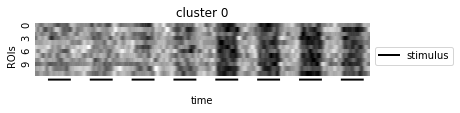

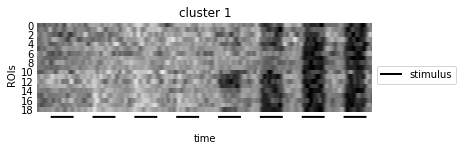

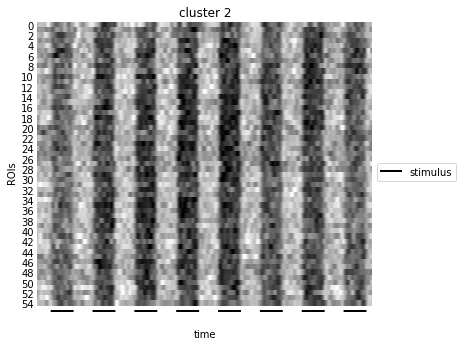

In [40]:
"""
final plot
"""

save=False


glue_pts = 0 # 511 ca. 1sec 

for i in range(0,3):
    n_traces = len(partition[i])
    plt.figure(1, figsize=(6,int(n_traces)/10))
    plt.title('cluster %i'%i)
    sns.heatmap(#np.hstack([data[partition[i],-glue_pts:],data[partition[i]]]),
                data[partition[i]],
               cbar=False,
               cmap='binary',  #'Greys'
               #center=0
               vmin=np.min(data),
               vmax=np.max(data))
    
    # plot stimulus
    #stim_glue = np.hstack([np.ones(glue_pts)*np.nan, stim_nan])
    stim_glue = stim_nan
    plt.plot(np.arange(0, len(stim_glue)),
             stim_glue*n_traces+1,
            c='black',
            lw=2,
            label='stimulus')
    
    plt.ylim(n_traces+3,0)
    #plt.ytick(None)
    plt.xlabel('time')
    plt.ylabel('ROIs')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    plt.tick_params(axis='both', which='both', length=0)
    ax = plt.gca()
    ax.set_xticklabels([])
    #ax.set_yticklabels([])

    
    if save:
        filename = 'heatmap_cluster_'+str(i)
        plt.savefig(filename+'.png', dpi=600, format='png',  bbox_inches='tight')
    plt.show()